<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/ml_caching_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Activation, CuDNNGRU, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler
from collections import OrderedDict, defaultdict
from google.colab import drive
import time
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [10, 8]

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
train = np.load('drive/My Drive/train_set.npy')
train.shape

(27222, 100, 9)

### Simple GRU (1 Feature - 7 timesteps - 1 prediction)

In [2]:
window = 7
num_features = 1
model = Sequential()
model.add(CuDNNGRU(64, input_shape=(window, num_features)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [4]:
# each sample has 9 features: 
# visits, year, month, day, weekday, weekend, mean, median, std
scaler = MinMaxScaler()
flattened_train = train.reshape(-1, 9)
scaler.fit(flattened_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# reshape training set


# reshaped_x = []
# reshaped_y = []
# for i in range(train.shape[0]): # for each content type
#   if i % 1000 == 0:
#     print(i,'/',train.shape[0])
#   for j in range(window, train.shape[1]): # for each timestep
#     reshaped_x.append([])
#     for w in range(window):
#       norm_x = scaler.transform(train[i, j-window+w, :].reshape(1, -1))
#       reshaped_x[-1].append(norm_x[:,0]) # add timestep
#     norm_y = scaler.transform(train[i, j, :].reshape(1, -1))
#   reshaped_y[-1].append(norm_y[:,0]) # add true label
# reshaped_x = np.asarray(reshaped_x, dtype='float')
# reshaped_y = np.asarray(reshaped_y, dtype='float')

In [0]:
# np.save('drive/My Drive/reshaped_x.npy', reshaped_x)
reshaped_x = np.load('drive/My Drive/reshaped_x.npy')

In [0]:
# np.save('drive/My Drive/reshaped_y.npy', reshaped_y)
reshaped_y = np.load('drive/My Drive/reshaped_y.npy')

In [9]:
model.fit(reshaped_x[:,:,:], reshaped_y[:], epochs = 1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2531646/2531646 [==============================] - 393s 155us/step - loss: 7.1378e-07


In [10]:
test = np.load('drive/My Drive/test_set.npy')
test.shape

(27222, 100, 9)

In [13]:
# preprend last 7 days of training set to caching set
train_end = train[:,-7:,:]
test = np.hstack((train_end, test))
test.shape

(27222, 107, 9)

In [25]:
# caching test (proactive) - (without online training)

cache_size = int(0.01 * test.shape[0])
hit_ratios = []
for i in range(window, test.shape[1]): # for each timestep
  print(i)
  preds = [] # predicted popularities for all objects at time i
  true_labels = [] # actual popularities for all objects at time i
  for j in range(test.shape[0]): # for each content
    training_sample = []
    for w in range(window):
      norm_x = scaler.transform(test[j, i-window+w, :].reshape(1, -1))
      training_sample.append(norm_x[:,0])
    pred = model.predict(np.asarray(training_sample).reshape(1,7,1))
    preds.append(np.asscalar(pred))
    norm_y = scaler.transform(test[j, i, :].reshape(1, -1))
    true_labels.append(np.asscalar(norm_y[:,0].flatten()))
  preds = np.asarray(preds)
  true_labels = np.asarray(true_labels)
  cached_items = np.argsort(preds)[::-1][:cache_size]
  total = np.sum(test[:,i,0])
  assert(total<500000)
  temp_hit_ratio = 0
  for item in cached_items:
    temp_hit_ratio += test[item, i, 0]/total
  hit_ratios.append(temp_hit_ratio)
print(sum(hit_ratios)/len(hit_ratios))

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
0.4343669751612323


0 / 27222


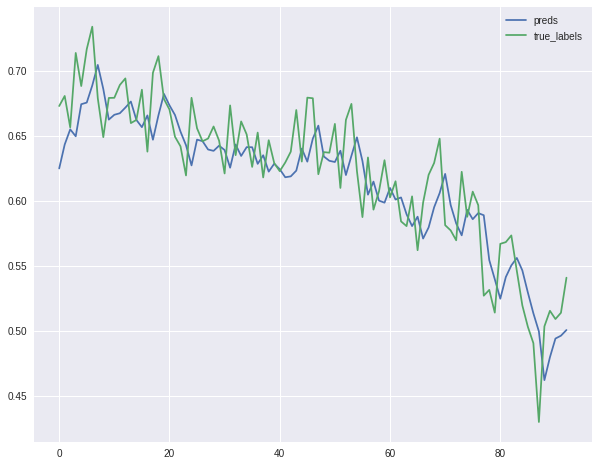

In [0]:
preds = []
true_labels = []
for i in range(1): # for each content type
  if i % 1000 == 0:
    print(i,'/',test.shape[0])
  for j in range(window, test.shape[1]): # for each timestep
    training_sample = []
    for w in range(window):
      norm_x = scaler.transform(test[i, j-window+w, :].reshape(1, -1))
      training_sample.append(norm_x[:,0])
    pred = model.predict(np.asarray(training_sample).reshape(1,7,1))
    preds.append(np.asscalar(pred)) # predict
    norm_y = scaler.transform(test[i, j, :].reshape(1, -1))
    true_labels.append(np.asscalar(norm_y[:,0].flatten())) # add true label
plt.plot(preds)
plt.plot(true_labels)
plt.legend(['preds','true_labels'])